In [53]:
import os
import numpy as np
from keras.preprocessing import image
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense, LeakyReLU, BatchNormalization
from keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
import matplotlib.pyplot as plt


In [2]:
class Dataset(object):

    def __init__(self, dataset_path):
        self.dataset_path = dataset_path

    def extract_dataset(self):
        images = []
        labels = []
        for subdir, dirs, files in os.walk(self.dataset_path):
            for filename in files:
                filepath = os.path.join(subdir, filename)
                if filepath.endswith(".jpg"):
                    label_parts = subdir.split(os.sep)
                    label = label_parts[-1] if label_parts[-1] != '' else label_parts[-2]  # Handling cases where the label might be the last part or second last part
                    images.append(filepath)
                    labels.append(label)

        return images, labels

In [3]:
# Data preprocessing

def preprocess_data(images, labels, img_size):
    processed_images = []
    label_encoder = LabelEncoder()
    integer_labels = label_encoder.fit_transform(labels)  # Encode string labels into integers
    print("Encoded Labels:", integer_labels)
    for img_path in images:
        img = image.load_img(img_path, target_size=img_size)
        img_array = image.img_to_array(img)
        processed_images.append(img_array)
    processed_images = np.array(processed_images) / 255.0
    labels = to_categorical(integer_labels)  # Convert integer labels to one-hot encoded vectors
    return processed_images, labels

In [4]:
# Load and preprocess dataset
obj = Dataset(dataset_path='15-Scene')
images, labels = obj.extract_dataset()

In [5]:
x, y = preprocess_data(images, labels, img_size=(150, 150))

Encoded Labels: [ 0  0  0 ... 13 13 13]


In [6]:
# Split data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [7]:
input_shape = x_train[0].shape
num_classes = len(np.unique(labels))
print("Number of classes:", num_classes)

Number of classes: 14


In [52]:
print(input_shape)

(150, 150, 3)


In [39]:
model = Sequential([
    Conv2D(32, (3, 3), padding='same', input_shape=input_shape),
    Conv2D(32, (3, 3), padding='same', activation=LeakyReLU(alpha=0.5)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), padding='same'),
    Conv2D(64, (3, 3), padding='same', activation=LeakyReLU(alpha=0.5)),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), padding='same'),
    Conv2D(128, (3, 3), padding='same', activation=LeakyReLU(alpha=0.5)),
    MaxPooling2D((2, 2)),
    Conv2D(256, (2, 2), padding='same'),
    Conv2D(256, (2, 2), padding='same', activation=LeakyReLU(alpha=0.5)),
    MaxPooling2D((2, 2)),
    Flatten(),
    BatchNormalization(),
    Dropout(0.2),
    Dense(512, activation='sigmoid'),
    Dropout(0.2),
    Dense(256, activation='sigmoid'),
    Dropout(0.1),
    Dense(num_classes, activation='softmax')
])


# Compile the model
model.compile(optimizer=Adam(), 
              loss='sparse_categorical_crossentropy', 
              metrics=['sparse_categorical_accuracy'],
              run_eagerly=True)

In [40]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_35 (Conv2D)          (None, 150, 150, 32)      896       
                                                                 
 conv2d_36 (Conv2D)          (None, 150, 150, 32)      9248      
                                                                 
 max_pooling2d_19 (MaxPooli  (None, 75, 75, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_37 (Conv2D)          (None, 75, 75, 64)        18496     
                                                                 
 conv2d_38 (Conv2D)          (None, 75, 75, 64)        36928     
                                                                 
 max_pooling2d_20 (MaxPooli  (None, 37, 37, 64)        0         
 ng2D)                                                

In [41]:
earlyStop = EarlyStopping(monitor = 'val_loss', patience = 10, restore_best_weights = True)

In [42]:
# Convert one-hot encoded labels back to integers
y_train_int = np.argmax(y_train, axis=1)
y_test_int = np.argmax(y_test, axis=1)

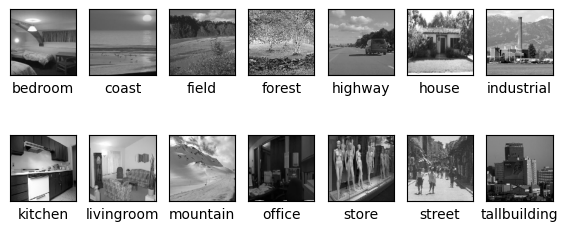

In [63]:
# Visualize one image from each class
classes = ['bedroom', 'coast', 'field', 'forest', 'highway', 'house', 'industrial',
           'kitchen', 'livingroom', 'mountain', 'office', 'store', 'street', 'tallbuilding']

plt.figure(figsize=(7, 3))
for i, class_name in enumerate(classes):
    # Find the index of the first image corresponding to the class
    idx = next(idx for idx, label in enumerate(y_train_int) if label == i)
    plt.subplot(2, 7, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[idx], cmap=plt.cm.binary)
    plt.xlabel(class_name)
plt.show()

In [43]:
print("Training data shape:", x_train.shape)
print("Training labels shape:", y_train_int.shape)
print("Testing data shape:", x_test.shape)
print("Testing labels shape:", y_test_int.shape)

Training data shape: (3341, 150, 150, 3)
Training labels shape: (3341,)
Testing data shape: (836, 150, 150, 3)
Testing labels shape: (836,)


In [44]:
model.fit(x_train, y_train_int, epochs=20, validation_data=(x_test, y_test_int), callbacks=[earlyStop])


Epoch 1/20
105/105 [==============================] - 170s 2s/step - loss: 1.8071 - sparse_categorical_accuracy: 0.3939 - val_loss: 2.3184 - val_sparse_categorical_accuracy: 0.2787
Epoch 2/20
105/105 [==============================] - 169s 2s/step - loss: 1.3975 - sparse_categorical_accuracy: 0.5142 - val_loss: 2.3739 - val_sparse_categorical_accuracy: 0.2656
Epoch 3/20
105/105 [==============================] - 158s 2s/step - loss: 1.2303 - sparse_categorical_accuracy: 0.5687 - val_loss: 1.7912 - val_sparse_categorical_accuracy: 0.3636
Epoch 4/20
105/105 [==============================] - 159s 2s/step - loss: 1.1405 - sparse_categorical_accuracy: 0.5980 - val_loss: 3.0734 - val_sparse_categorical_accuracy: 0.2189
Epoch 5/20
105/105 [==============================] - 162s 2s/step - loss: 1.0619 - sparse_categorical_accuracy: 0.6193 - val_loss: 1.7860 - val_sparse_categorical_accuracy: 0.4055
Epoch 6/20
105/105 [==============================] - 161s 2s/step - loss: 1.0304 - sparse_cate

In [45]:
model.fit(x_train, y_train_int, epochs=30, validation_data=(x_test, y_test_int), callbacks=[earlyStop])

Epoch 1/30
105/105 [==============================] - 263s 3s/step - loss: 0.3193 - sparse_categorical_accuracy: 0.8982 - val_loss: 1.1886 - val_sparse_categorical_accuracy: 0.6352
Epoch 2/30
105/105 [==============================] - 268s 3s/step - loss: 0.3061 - sparse_categorical_accuracy: 0.8997 - val_loss: 1.1423 - val_sparse_categorical_accuracy: 0.6567
Epoch 3/30
105/105 [==============================] - 280s 3s/step - loss: 0.2591 - sparse_categorical_accuracy: 0.9189 - val_loss: 1.0960 - val_sparse_categorical_accuracy: 0.6938
Epoch 4/30
105/105 [==============================] - 282s 3s/step - loss: 0.2432 - sparse_categorical_accuracy: 0.9213 - val_loss: 1.2334 - val_sparse_categorical_accuracy: 0.6519
Epoch 5/30
105/105 [==============================] - 289s 3s/step - loss: 0.2159 - sparse_categorical_accuracy: 0.9330 - val_loss: 1.0786 - val_sparse_categorical_accuracy: 0.6902
Epoch 6/30
105/105 [==============================] - 293s 3s/step - loss: 0.1950 - sparse_cate

In [47]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns

# Make predictions on test data
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)

27/27 [==============================] - 19s 707ms/step


In [48]:
# Print classification report
print("Classification Report:")
print(classification_report(y_test_int, y_pred_classes))

# Print accuracy
accuracy = accuracy_score(y_test_int, y_pred_classes)
print("Accuracy:", accuracy)

Classification Report:
              precision    recall  f1-score   support

           0       0.51      0.46      0.48        57
           1       0.74      0.76      0.75        80
           2       0.72      0.67      0.69        81
           3       0.87      0.89      0.88        81
           4       0.81      0.69      0.74        51
           5       0.90      0.85      0.87        52
           6       0.64      0.46      0.53        50
           7       0.51      0.43      0.47        42
           8       0.45      0.60      0.52        65
           9       0.73      0.87      0.79        62
          10       0.79      0.60      0.68        45
          11       0.66      0.76      0.71        54
          12       0.70      0.86      0.78        58
          13       0.84      0.79      0.81        58

    accuracy                           0.71       836
   macro avg       0.71      0.69      0.69       836
weighted avg       0.71      0.71      0.70       836

Ac

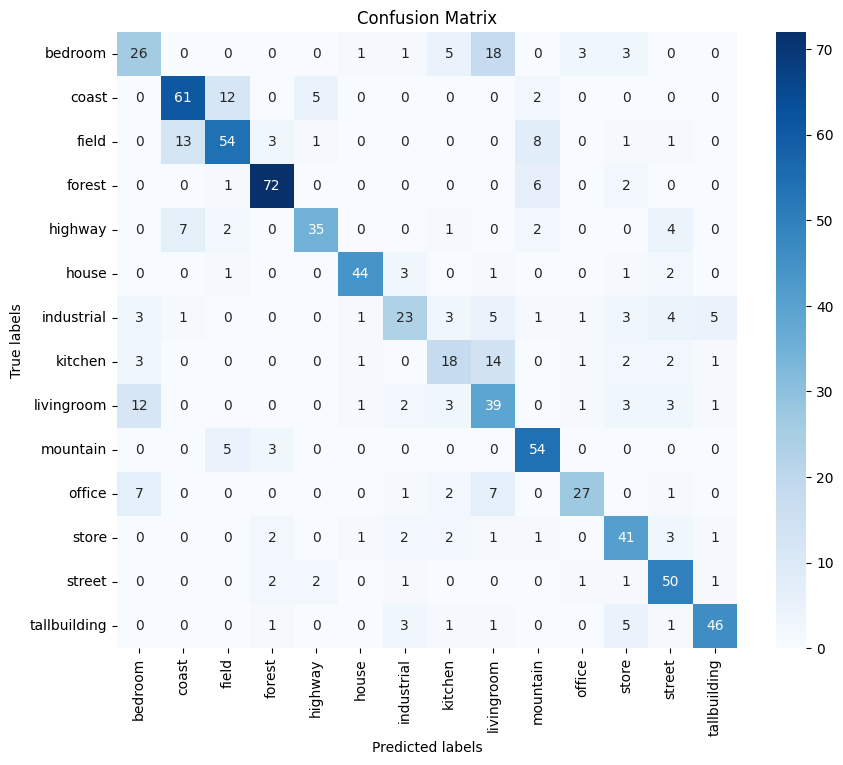

In [51]:
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test_int, y_pred_classes)
# Define the class labels
classes = ['bedroom', 'coast', 'field', 'forest', 'highway', 'house', 'industrial',
           'kitchen', 'livingroom', 'mountain', 'office', 'store', 'street', 'tallbuilding']

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [64]:
print(cm)

[[26  0  0  0  0  1  1  5 18  0  3  3  0  0]
 [ 0 61 12  0  5  0  0  0  0  2  0  0  0  0]
 [ 0 13 54  3  1  0  0  0  0  8  0  1  1  0]
 [ 0  0  1 72  0  0  0  0  0  6  0  2  0  0]
 [ 0  7  2  0 35  0  0  1  0  2  0  0  4  0]
 [ 0  0  1  0  0 44  3  0  1  0  0  1  2  0]
 [ 3  1  0  0  0  1 23  3  5  1  1  3  4  5]
 [ 3  0  0  0  0  1  0 18 14  0  1  2  2  1]
 [12  0  0  0  0  1  2  3 39  0  1  3  3  1]
 [ 0  0  5  3  0  0  0  0  0 54  0  0  0  0]
 [ 7  0  0  0  0  0  1  2  7  0 27  0  1  0]
 [ 0  0  0  2  0  1  2  2  1  1  0 41  3  1]
 [ 0  0  0  2  2  0  1  0  0  0  1  1 50  1]
 [ 0  0  0  1  0  0  3  1  1  0  0  5  1 46]]
